## Using APIs

### American Community Survey

The [American Community Survey](https://www.census.gov/programs-surveys/acs)(ACS) is the largest survey conducted by the U.S. Census Bureau.  It collects basic demographic information about people living across the United States.

The survey is conducted every year, and, due to processing time, releases with a lag.  For instance, the 2018 survey data is released in the latter part of 2019.  The ACS data is relased not only in one-year estimates (e.g. 2018 survey data) but also in five-year estimates (e.g. 2014-2018 survey data).  The one-year estimates are, naturally, more recent.  However, five-year estimates may be necessary in some applications.  The Census Bureau does not release survey information for small populations, due to anonymity concerns, every year.  Rather, some information is available exclusively in the five-year survey data (which averages over a five year period).

A brief overview of the data available through the ACS is available [here](https://www.census.gov/acs/www/data/data-tables-and-tools/).  Note that the ACS data includes things like age, marital status, income, employment status, and educational attainment.

The full list of ACS data is available [here](https://api.census.gov/data/2018/acs/acs1/profile/variables/).

Register for an API key with the U.S. Census Bureau [here](https://api.census.gov/data/key_signup.html).  This step is **required** to continue with the lecture notes!

Enter your API key as a string here:

In [1]:
api_key = ''

To keep my key secret, I've pickled the string that stores it, and will re-load it here.  *Do not* attempt to run the following block.

In [2]:
import pickle
with open('census_key.p', 'rb') as f:
    api_key = pickle.load(f)

The formula to get data from the ACS is:

```
'https://api.census.gov/data/'
+ <year>
+ '/acs/acs1?get=NAME,'
+ <variable name>
+ '&for='
+ <geography>
+ ':*&key='
+ <API key>
```

For instance, to get median household income (which has `<variable name> = B19013_001E`) for `<year> = 2010` over the entire U.S. (`<geography> = us`), we would use the string

`'https://api.census.gov/data/' + '2010' + '/acs/acs1?get=NAME,' + 'B19013_001E' + '&for=' + 'us' + ':*&key=' + api_key`

as our URL.  An example request is shown below:

In [3]:
import requests
r = requests.get('https://api.census.gov/data/2010/acs/acs1?get=NAME,B19013_001E&for=us:*&key='+api_key).json()
print(r)

[['NAME', 'B19013_001E', 'us'], ['United States', '50046', '1']]


Likewise, to get data for *every* county in the country, we would replace `us` with `county` following the `for=` piece of the string.  This will return data on many counties.  Instead of printing them all, below, we've printed just a sample, as well as the total number of counties for which median household income data is available via ACS.

In [4]:
r = requests.get('https://api.census.gov/data/2010/acs/acs1?get=NAME,B19013_001E&for=county:*&key='+api_key).json()
print(r[0:10])
print(len(r))

[['NAME', 'B19013_001E', 'state', 'county'], ['Baldwin County, Alabama', '47502', '01', '003'], ['Calhoun County, Alabama', '36675', '01', '015'], ['Cullman County, Alabama', '35786', '01', '043'], ['DeKalb County, Alabama', '35967', '01', '049'], ['Elmore County, Alabama', '52222', '01', '051'], ['Etowah County, Alabama', '35897', '01', '055'], ['Houston County, Alabama', '38579', '01', '069'], ['Jefferson County, Alabama', '41583', '01', '073'], ['Lauderdale County, Alabama', '38661', '01', '077']]
819


Note that the first item in this list is:

In [5]:
print(r[0])

['NAME', 'B19013_001E', 'state', 'county']


which is simply a set of headers.  That is, for each additional item in the list, the data in position 0 is the county name and the data in position 1 corresponds to the value for the variable `B19013_001E`.  The numbers in positions 2 and 3 are the county's FIPS code.  States have 2-digit FIPS codes, and counties have 3-digit FIPS codes.  If we put the state code and county code together to a 5-digit number (state code then county code), we have a unique identifier for the county.  This FIPS code is used by many different data providers.

Recall that we can remove an element from a list with the `.pop()` function.  For instance, let's remove the first element of our requested ACS data (the set of headers).

In [6]:
headers = r.pop(0)

Do not run the above line of code multiple times!  Python will continue popping out elements of your list.

The value for `headers` is thus:

In [7]:
print(headers)

['NAME', 'B19013_001E', 'state', 'county']


as expected.  Now, the requested ACS data no longer has that element.  Rather, what is left is

In [8]:
print(r[0:10])

[['Baldwin County, Alabama', '47502', '01', '003'], ['Calhoun County, Alabama', '36675', '01', '015'], ['Cullman County, Alabama', '35786', '01', '043'], ['DeKalb County, Alabama', '35967', '01', '049'], ['Elmore County, Alabama', '52222', '01', '051'], ['Etowah County, Alabama', '35897', '01', '055'], ['Houston County, Alabama', '38579', '01', '069'], ['Jefferson County, Alabama', '41583', '01', '073'], ['Lauderdale County, Alabama', '38661', '01', '077'], ['Lee County, Alabama', '39381', '01', '081']]


simply data.  This is useful, because we can not store all of the data we have in a DataFrame.  The command to do this is `pd.DataFrame()`.  This function takes two arguments.  First, Python expects to receive a list of lists.  This list of lists should correspond to the data that we want to store.  The list of list is a list of rows of data, where each row may be a list of multiple values (multiple columns).  The second argument is a list of column names.

In [9]:
import pandas as pd
census = pd.DataFrame(r, columns=headers)
census.head()

,NAME,B19013_001E,state,county
0,"Baldwin County, Alabama",47502,01,003
1,"Calhoun County, Alabama",36675,01,015
2,"Cullman County, Alabama",35786,01,043
3,"DeKalb County, Alabama",35967,01,049
4,"Elmore County, Alabama",52222,01,051


In [10]:
census['state'] = census['state'].astype(int)
census['county'] = census['county'].astype(int)

In [11]:
census.dtypes

NAME           object
B19013_001E    object
state           int64
county          int64
dtype: object

In [12]:
census['B19013_001E'] = census['B19013_001E'].astype(int)

### Zillow Home Values

County median incomes give a sense of the economic well-being of a geographic area.  Suppose that our interest is in how home prices (for most households, the most valuable asset that the household owns), correlates with income.

Housing data is available from Zillow [here](https://www.zillow.com/research/data/).

The URL for data on all home prices in a county (single-family residential and condos) is `'http://files.zillowstatic.com/research/public_v2/zhvi/County_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv'`.  Pandas can read online csv files directly in to Python.

In [13]:
zhvi = pd.read_csv('http://files.zillowstatic.com/research/public_v2/zhvi/County_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv')

The `.shape` property of a Pandas DataFrame reports the numbers of rows and columns.

In [14]:
zhvi.shape

(2850, 306)

There are a lot of columns on this file!  Recall that the `.columns` property of a DataFrame returns a list of columns.  Recall too that we can subset a list named `x` to items `m` through `n` via `x[m:n]`.  Thus, print out only the first 20 columns of the DataFrame below (to get a sense of what's included on this DataFrame).

In [15]:
zhvi.columns[:20]

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS', '1996-01-31',
       '1996-02-29', '1996-03-31', '1996-04-30', '1996-05-31', '1996-06-30',
       '1996-07-31', '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30'],
      dtype='object')

Likewise, the *last* `n` items of list `x` are accessible via `x[-n:]`.

In [16]:
zhvi.columns[-20:]

Index(['2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
       '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
       '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
       '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30'],
      dtype='object')

Given what we observe about the data, define a list of column names to keep.  All other columns outside of this list will be removed.

In [17]:
keep_list = [col for col in zhvi.columns[:9]] + ['2018-12-31']
print(keep_list)

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS', '2018-12-31']


In [18]:
zhvi = zhvi[keep_list]

In [19]:
print(zhvi.head())

   RegionID  SizeRank          RegionName RegionType StateName State  \
0      3101         0  Los Angeles County     County        CA    CA   
1       139         1         Cook County     County        IL    IL   
2      1090         2       Harris County     County        TX    TX   
3      2402         3     Maricopa County     County        AZ    AZ   
4      2841         4    San Diego County     County        CA    CA   

                              Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0    Los Angeles-Long Beach-Anaheim              6                 37   
1          Chicago-Naperville-Elgin             17                 31   
2  Houston-The Woodlands-Sugar Land             48                201   
3           Phoenix-Mesa-Scottsdale              4                 13   
4                San Diego-Carlsbad              6                 73   

   2018-12-31  
0    640852.0  
1    256662.0  
2    198043.0  
3    282261.0  
4    610196.0  


We will combine datasets using state and county codes.  Check that the ZHVI data imported as numbers.

In [20]:
zhvi.dtypes

RegionID               int64
SizeRank               int64
RegionName            object
RegionType            object
StateName             object
State                 object
Metro                 object
StateCodeFIPS          int64
MunicipalCodeFIPS      int64
2018-12-31           float64
dtype: object

Now we can merge.  The format for merging `df1` and `df2` is to use `df1.merge(df2, left_on=, right_on=)`.  The `left_on` and `right_on` specify variables on the left (`df11)` and right (`df2`) datasets that should link the datasets together.  Note that `df1` is the left dataset because it appears before `.merge`, whereas `df2` is the right data because it appears after `.merge`.  It is also possible to use `df2.merge(df1, left_on=, right_on=)`.  In this scenario, the lists passed to `left_on` and `right_on` would flip from the earlier usage (since now `df2` is the left dataset).

In [21]:
df = zhvi.merge(census, left_on=['StateCodeFIPS','MunicipalCodeFIPS'], right_on=['state','county'])

In [22]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2018-12-31,NAME,B19013_001E,state,county
0,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,640852.0,"Los Angeles County, California",52684,6,37
1,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,256662.0,"Cook County, Illinois",51466,17,31
2,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,198043.0,"Harris County, Texas",50422,48,201
3,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,282261.0,"Maricopa County, Arizona",50410,4,13
4,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,610196.0,"San Diego County, California",59923,6,73


This merged dataset has both county median income and an index of home values in the area.  Are income and home prices correlated?  We can quickly visualize the question with `seaborn`.

In [23]:
import seaborn as sns

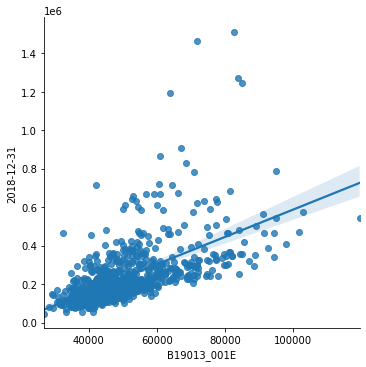

In [24]:
sns.lmplot(x='B19013_001E', y='2018-12-31', data=df)

There do appear to be some outliers here.  To check, try a boxplot.

/mnt/software/anaconda3/envs/fds/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='2018-12-31'>

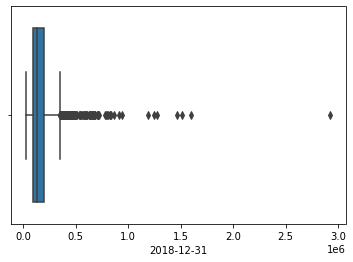

In [25]:
sns.boxplot(zhvi['2018-12-31'])

Additionally, print out a description of the home value index data.

In [26]:
zhvi['2018-12-31'].describe()

count    2.850000e+03
mean     1.667050e+05
std      1.307382e+05
min      2.544400e+04
25%      9.602900e+04
50%      1.330440e+05
75%      1.979808e+05
max      2.925333e+06
Name: 2018-12-31, dtype: float64

One method of removing outliers is to ignore (i.e. delete) the data that is "far out" on the boxplot (i.e., well beyond the whiskers).

The `numpy` module has a `quantile()` function to retrieve the 25th and 75th percentiles, as reported above in the summary statistics.

In [27]:
import numpy as np
quantiles = np.quantile(zhvi['2018-12-31'], q=[.25, .75])
print(quantiles)

[ 96029.   197980.75]


The interquartile range (IQR) is defined as the difference between the 75th and 25th percentiles of data.  One reasonable way to remove outliers is to eliminate observations that exceed the 75th percentile by more than 1.5\*IQR or are less than the 25th percentile by more than 1.5\*IQR.

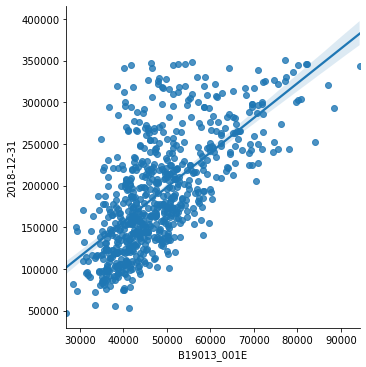

In [28]:
iqr = quantiles[1]-quantiles[0]
sns.lmplot(x='B19013_001E', y='2018-12-31', data=df[ (df['2018-12-31'] < quantiles[1]+1.5*iqr) &
                                                   (df['2018-12-31'] > quantiles[0]-1.5*iqr) ])